In [1]:
# Import packages:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time

np.random.seed(0)

In [2]:
# QUESTION 4: Functions

# RBF Function
# INPUT: All datasets (NxD np.arrays (X), Nx1 np.arrays (Y)), dataset type (str: 'reg' or 'class')
# OUTPUT: Return True if successful, False else
def RBF(x_train, y_train, x_valid, y_valid, x_test, y_test, data_type):
    shape = np.array([0.05, 0.1, 0.5, 1, 2])
    reg = np.array([0.001, 0.01, 0.1, 1])
    
    for theta in shape:
        for l in reg:
            # Calculation of Gram matrix
            K = gaussian_RBF(x_train, x_train, theta)

            # Cholesky Factorization
            a = (K + l*(np.identity(K.shape[0])))
            RTR = sp.linalg.cho_factor(a)
            alpha = sp.linalg.cho_solve(RTR,y_train)
                                    
            # Find y_pred
            K_valid = gaussian_RBF(x_valid, x_train, theta)
            y_pred = np.dot(K_valid,alpha)
            
            # Find loss/accuracy
            if data_type == "reg":
                out = RMSEloss(y_valid,y_pred)
            elif data_type == "class":
                out = accuracy(y_valid,y_pred)                       
            else:
                print("Error: Invalid Data Type")
                return False
            
            print("TRAINING | Type of task: {} | Theta Value: {} | Lambda Value: {} | Loss/Accuracy: {}".format(data_type, theta, l, out))
    
    theta = float(input("Enter your desired theta value: "))
    l = float(input("Enter your desired lambda value: "))

    # Combine training and validation x values
    x_comb = np.vstack((x_train, x_valid))
    y_comb = np.vstack((y_train, y_valid))
      
    # Calculation of Gram matrix
    K = gaussian_RBF(x_comb, x_comb, theta)

    # Cholesky Factorization
    a = (K + l*(np.identity(K.shape[0])))
    RTR = sp.linalg.cho_factor(a)
    alpha = sp.linalg.cho_solve(RTR,y_comb)
    
    # Find y_pred for test
    K_test = gaussian_RBF(x_test, x_comb, theta)
    y_pred = np.dot(K_test,alpha)

    # Find loss/accuracy
    if data_type == "reg":
        out = RMSEloss(y_test,y_pred)
    elif data_type == "class":
        out = accuracy(y_test,y_pred)                       
    else:
        print("Error: Invalid Data Type")
        return False

    print("TESTING | Type of task: {} | Theta Value: {} | Lambda Value: {} | Loss/Accuracy: {}".format(data_type, theta, l, out))
    
    return True
        
# Gram Matrix RBF Helper Function
# INPUT: X values (np.array)
# OUTPUT: K matrix (np.array)
def gaussian_RBF(mat1, mat2, theta):
    K = np.zeros((mat1.shape[0],mat2.shape[0]))
    for i in range(mat1.shape[0]):
        for j in range(mat2.shape[0]):
            K[i,j] = np.exp(-np.square(np.linalg.norm(mat1[i]-mat2[j]))/theta)
    return K
    
# Accuracy Function
# INPUT: Real Y array, predicted Y array (Nx(# of classes) np.arrays)
# OUTPUT: Accuracy of results (float percentage)
def accuracy(y_real,y_pred):
    count = 0
    for line in range(y_real.shape[0]):
        if np.argmax(y_real[line])==np.argmax(y_pred[line]):
            count+=1
    return (count/(y_real.shape[0]))*100

# RMSE Loss Function
# INPUT: Predicted Y array, actual Y array (NxD np.arrays)
# OUTPUT: Loss (float)
def RMSEloss(y_real,y_pred):
    return np.sqrt(np.mean((y_pred-y_real)**2))

In [3]:
# QUESTION 4: Main
from data_utils import load_dataset

# 1. Uncomment the dataset you'd like to work with.

# print("Working with 'mauna_loa'...")
# x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')

# print("Working with 'rosenbrock'...")
# x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', n_train=1000, d=2)

print("Working with 'iris'...")
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('iris')

# 2. Run the RBF training function across the parameter grids to tune hyperparameters; enter desired hyperparameters
# when prompted to test:
RBF(x_train, y_train, x_valid, y_valid, x_test, y_test, 'class')

Working with 'iris'...
TRAINING | Type of task: class | Theta Value: 0.05 | Lambda Value: 0.001 | Loss/Accuracy: 80.64516129032258
TRAINING | Type of task: class | Theta Value: 0.05 | Lambda Value: 0.01 | Loss/Accuracy: 80.64516129032258
TRAINING | Type of task: class | Theta Value: 0.05 | Lambda Value: 0.1 | Loss/Accuracy: 80.64516129032258
TRAINING | Type of task: class | Theta Value: 0.05 | Lambda Value: 1.0 | Loss/Accuracy: 80.64516129032258
TRAINING | Type of task: class | Theta Value: 0.1 | Lambda Value: 0.001 | Loss/Accuracy: 83.87096774193549
TRAINING | Type of task: class | Theta Value: 0.1 | Lambda Value: 0.01 | Loss/Accuracy: 83.87096774193549
TRAINING | Type of task: class | Theta Value: 0.1 | Lambda Value: 0.1 | Loss/Accuracy: 80.64516129032258
TRAINING | Type of task: class | Theta Value: 0.1 | Lambda Value: 1.0 | Loss/Accuracy: 80.64516129032258
TRAINING | Type of task: class | Theta Value: 0.5 | Lambda Value: 0.001 | Loss/Accuracy: 83.87096774193549
TRAINING | Type of t

True

In [115]:
# QUESTION 5: Functions
import math

# INPUT: All datasets (NxD np.arrays (X), Nx1 np.arrays (Y))
# OUTPUT: Return True if successful, False else
def greedy_regression(x_train, x_valid, x_test, y_train, y_valid, y_test):
    
    # Combine training, validation
    x_comb = np.vstack((x_train, x_valid))
    y_comb = np.vstack((y_train, y_valid))
    
    # Construct dictionary of basis functions
    basis_fcns = {}
    
    for i in range(1,100):
        basis_fcns[i] = lambda x, i=i: np.sin(math.pi*i*x)
    
    it = 0
    for i in range(100,200):
        basis_fcns[i] = lambda x, it=it: np.cos(math.pi*i*x)
        it += 1

    it = 0
    for i in range(200,400):
        basis_fcns[i] = lambda x, it=it: np.power(x,it)
        it += 1
    
    # Construct indices sets
    I_s = []
    I_c = np.arange(1,400).tolist()
    
    # Establish vars for while loop
    r = y_comb
    loss = np.sqrt(sum(np.square(r)))
    MDL = (y_comb.shape[0]/2)*np.log(loss)
    k = 0
    
    # Perform greedy selection
    while True:
        k += 1
        
        # Pick a new basis function from the dictionary
        J_max = 0
        i_k = 0
        for i in I_c:
            J = (np.dot(np.transpose(basis_fcns[i](x_comb)),r)**2)/(np.dot(np.transpose(basis_fcns[i](x_comb)),basis_fcns[i](x_comb)))
            if J > J_max:
                J_max = J
                i_k = i
        
        # Update I arrays
        I_s += [i_k]
        I_c.remove(i_k)
        
        # Solve for the weights 
        if k == 1:
            phi_comb = basis_fcns[I_s[0]](x_comb)
        else:
            phi_comb = np.c_[phi_comb, basis_fcns[I_s[k-1]](x_comb)]
        Q, R = sp.linalg.qr(phi_comb, mode='economic')
        w = np.dot(np.linalg.inv(R),np.transpose(Q))
        w = np.dot(w,y_comb)
        
        # Find validation error, update MDL
        r = y_comb - np.matmul(phi_comb, w)
        loss = np.sqrt(sum(np.square(r)))
        MDL_current = (y_comb.shape[0]/2)*np.log(loss) + (k/2)*np.log(x_comb.shape[0])
        if MDL_current >= MDL:
            break
        MDL = MDL_current
    
    # Use basis functions on test set
    phi_test = basis_fcns[I_s[0]](x_test)
    for i in I_s[1:]:
        phi_test = np.c_[phi_test, basis_fcns[i](x_test)]
    y_pred = np.matmul(phi_test, w)
    rmse = RMSEloss(y_test,y_pred)
    print("TEST SET LOSS: {}".format(rmse))
    
    # Plot the function
    plt.plot(x_test, y_test, '.', color='black', label = "Test Data")
    plt.plot(x_test, y_pred, label = "Predicted Trend")
    plt.xlabel("Time (months)")
    plt.ylabel("CO2 Measurements")
    plt.title("Predictions on Mauna Loa Dataset Using Greedy Algorithm")
    plt.legend()
    plt.show()
    
    return True

# RMSE Loss Function
# INPUT: Predicted Y array, actual Y array (NxD np.arrays)
# OUTPUT: Loss (float)
def RMSEloss(y_real,y_pred):
    return np.sqrt(np.mean((y_pred-y_real)**2))

Working with 'mauna_loa'...
TEST SET LOSS: 0.10168438277426178


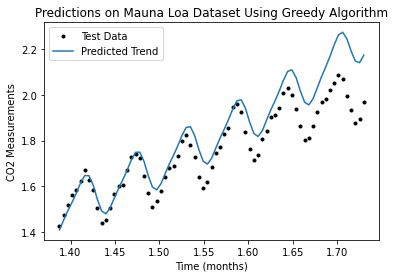

True

In [116]:
# QUESTION 5: Main

# 1. Load mauna_loa dataset

print("Working with 'mauna_loa'...")
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')


# 2. Run greedy algorithm
greedy_regression(x_train, x_valid, x_test, y_train, y_valid, y_test)